# IMDb Sentiment Analysis with Deep Learning

(Work in progress) 

In this project, we build and evaluate a deep learning model to perform **binary sentiment classification** on movie reviews from the **IMDb dataset**. The goal is to determine whether a given review expresses a **positive** or **negative** sentiment, a classic **natural language processing (NLP)** task with broad applications in industry—from customer feedback monitoring to market research. We use the prototypical IMDb datasets.

## Approach

We use a **recurrent neural network (RNN)** based architecture, specifically an **LSTM (Long Short-Term Memory)** model, which is well-suited for sequential data like text. The network includes:

- An **embedding layer** trained from scratch to represent words in dense vector space  
- Two stacked **LSTM layers** to capture temporal dependencies  
- A **dense hidden layer** followed by **dropout** for regularization  
- A final **sigmoid-activated output layer** for binary classification  

The model is trained using the **binary cross-entropy** loss function and evaluated on accuracy using a hold-out validation set.

## Evaluation

We track model performance using:
- **Training and validation accuracy/loss over epochs**
- Final model accuracy on the test set

Further improvements could include experimenting with **pre-trained word embeddings (e.g., GloVe)**, **bidirectional LSTMs**, or **transformer-based models**.

---

This project demonstrates a complete deep learning pipeline for a real-world NLP task and serves as a strong foundation for more advanced text classification work.


In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 
import time
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Load the IMDb dataset provided by Keras
dataset = keras.datasets.imdb

# Load data, keeping only the most frequent words (e.g., 10,000 words)
num_words = 10000
(x_train, y_train), (x_test, y_test) = dataset.load_data(num_words=num_words)

# Check dataset dimensions
print(f"Training set size: {x_train.shape}, Test set size: {x_test.shape}")

# Decode an example to understand the dataset format
word_index = dataset.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

def decode_review(text):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in text])

print("Example of decoded review:")
print(decode_review(x_train[0]))

Training set size: (25000,), Test set size: (25000,)
Example of decoded review:
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these 

In [3]:
# Data preprocessing
max_len = 500  # Maximum sequence length
x_train = pad_sequences(x_train, maxlen=max_len, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post', truncating='post')

In [4]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

print("Max token index in x_train:", np.max(x_train))
print("Min token index in x_train:", np.min(x_train))

print("Example padded sequence:", x_train[0][:50])


x_train shape: (25000, 500)
x_test shape: (25000, 500)
Max token index in x_train: 9999
Min token index in x_train: 0
Example padded sequence: [   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447]


### Baseline LSTM Model with Trainable Embedding

We now build our baseline deep learning model for sentiment classification using a stack of **Long Short-Term Memory (LSTM)** layers. 

In this architecture:
- We include an **embedding layer trained from scratch**, allowing the model to learn word representations directly from the IMDb dataset.
- Two **stacked LSTM layers** are used to capture both short-term and long-term dependencies in the sequence data.
- A **dense layer with ReLU activation** and **dropout** is added to enhance the model's ability to generalize.
- A final **sigmoid-activated output layer** performs binary classification.

The model is compiled with the **binary cross-entropy loss** and the **Adam optimizer**, and it is trained using a standard batch size of 32 for 10 epochs.


/home/giov_armando/jupyter_env/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-03-26 14:33:24.509622: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 331s 420ms/step - accuracy: 0.5088 - loss: 0.6928 - val_accuracy: 0.5058 - val_loss: 0.6930
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 325s 416ms/step - accuracy: 0.5083 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6922
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 333s 427ms/step - accuracy: 0.5045 - loss: 0.7048 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 338s 433ms/step - accuracy: 0.4943 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 347s 444ms/step - accuracy: 0.4984 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 349s 446ms/step - accuracy: 0.5032 - loss: 0.6931 - val_accuracy: 0.5052 - val_loss: 0.6931
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 340s 435ms/step - accuracy: 0.5064 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 343s 439ms/step - accuracy: 0.5024 -

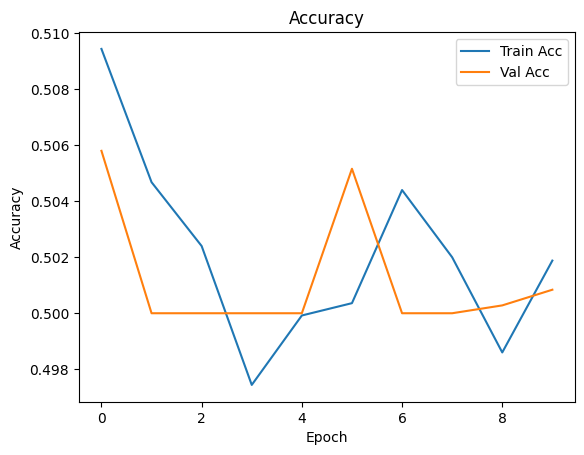

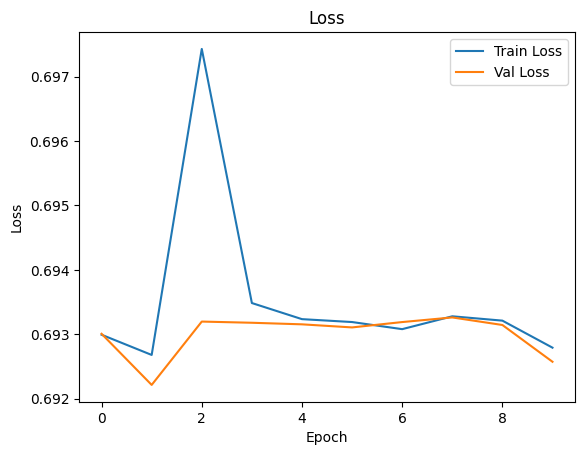

In [5]:
# Create the model with an embedding layer trained from scratch
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Use Adam optimizer with gradient clipping and reduced learning rate
optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Display model summary
model.summary()

start_time = time.time()

# Train the model
batch_size = 32
epochs = 10
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test)
)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.2f} seconds")

# Plotting training history
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see that this model begins converging significantly only after around **5 epochs**, which indicates that the learning rate **1e-4** might be too low, resulting in slow and inefficient training, and that the model might require additional epochs, more than the **10 epochs** we used here, to achieve meaningful improvements in accuracy.

To address these issues, we now:

- **Increase the learning rate** from **1e-4** to **1e-3**, enabling faster and smoother convergence.
- **Increase the maximum number of epochs** from **10** to **15** to give the model more opportunity to learn effectively.
- We also include **Early Stopping**, which will automatically halt training once the validation loss stops improving for two consecutive epochs. This ensures efficient use of computational resources while preventing overfitting.

Let's see how these changes affect the training process:

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 327s 415ms/step - accuracy: 0.5074 - loss: 0.6937 - val_accuracy: 0.4984 - val_loss: 0.6932
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 341s 436ms/step - accuracy: 0.5046 - loss: 0.6933 - val_accuracy: 0.5094 - val_loss: 0.6920
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 337s 431ms/step - accuracy: 0.5139 - loss: 0.6837 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 342s 437ms/step - accuracy: 0.5075 - loss: 0.6926 - val_accuracy: 0.5002 - val_loss: 0.6930
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 338s 432ms/step - accuracy: 0.4936 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 321s 410ms/step - accuracy: 0.4984 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932

Training time: 2004.83 seconds


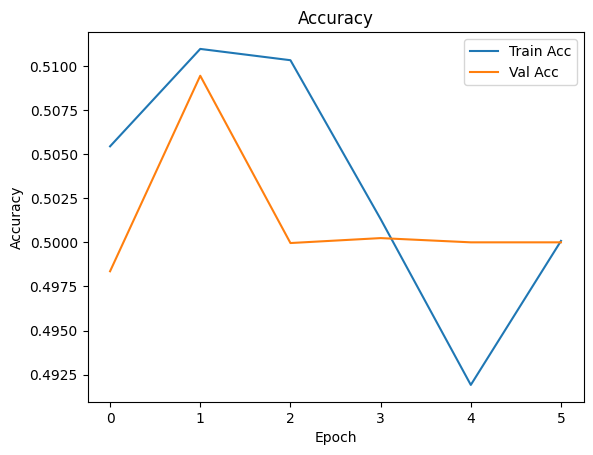

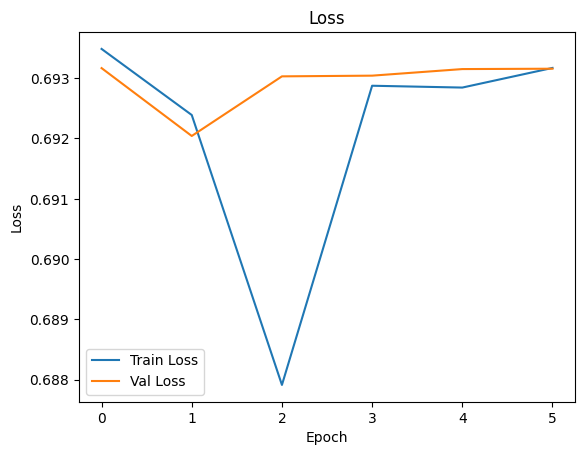

In [6]:
# Create the model with an embedding layer trained from scratch
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Adam optimizer with gradient clipping and increased learning rate
optimizer = Adam(learning_rate=1e-3, clipnorm=1.0)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Display model summary
model.summary()

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

start_time = time.time()

# Train the model
batch_size = 32
epochs = 15
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    callbacks=[early_stop]
)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.2f} seconds")

# Plotting training history
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Again, this model seems to struggle, indicating that the issues might not be related solely to the learning rate or the number of epochs. Instead, the problems might arise because the model is overly complex relative to the size of the dataset. Additionally, the chosen sequence length (**`max_len = 500`**) may be unnecessarily long, causing the LSTM layers to struggle in capturing relevant features efficiently.

To address these concerns, we'll now implement the following changes:

- **Reduce the sequence length** from **500** to **250**, which is usually sufficient for IMDb reviews.
- Introduce **Bidirectional LSTM layers** to improve context understanding and potentially boost accuracy.
- Retain both **gradient clipping** and **early stopping** to maintain stable training and avoid overfitting.

Let's see how these modifications influence our training results.


Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 129s 159ms/step - accuracy: 0.6599 - loss: 0.5932 - val_accuracy: 0.8303 - val_loss: 0.3854
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 126s 161ms/step - accuracy: 0.8845 - loss: 0.3248 - val_accuracy: 0.8466 - val_loss: 0.3617
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 129s 165ms/step - accuracy: 0.9092 - loss: 0.2578 - val_accuracy: 0.8442 - val_loss: 0.3677
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 126s 161ms/step - accuracy: 0.9308 - loss: 0.2154 - val_accuracy: 0.8379 - val_loss: 0.4253
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 128s 164ms/step - accuracy: 0.9347 - loss: 0.1877 - val_accuracy: 0.8414 - val_loss: 0.4323
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 125s 160ms/step - accuracy: 0.9501 - loss: 0.1518 - val_accuracy: 0.8323 - val_loss: 0.4808
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 127s 163ms/step - accuracy: 0.9561 - loss: 0.1365 - val_accuracy: 0.8414 - val_loss: 0.4846
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 125s 160ms/step - accuracy: 0.9690 -

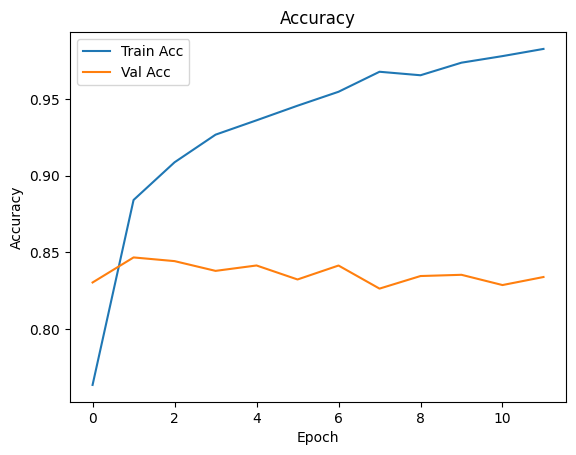

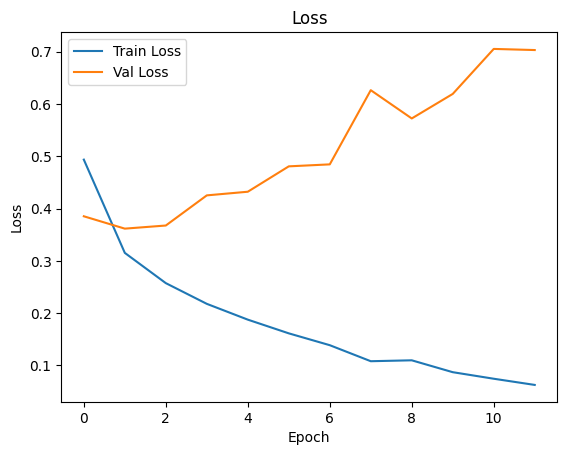

In [11]:
max_len = 250

x_train = pad_sequences(x_train, maxlen=max_len, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post', truncating='post')

model = Sequential([
    Embedding(input_dim=num_words, output_dim=64, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=5e-4, clipnorm=1.0)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


start_time = time.time()


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[early_stop]
)


end_time = time.time()

elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.2f} seconds")


# Plotting training history
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()